Capstone Project Hacktiv8 x IBM

By: Azzah M


---



# **ANALISIS SPAM PADA KOMENTAR YOUTUBE MUSIC VIDEO UNTUK OPTIMALISASI MODERASI KONTEN**





---




## Preparation

In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
Tesla T4


In [2]:
!pip install wordcloud
!pip install squarify

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud, STOPWORDS

In [4]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/포트폴리오/📊 데이터 분석/프로젝트 3/Youtube-Spam-Dataset.csv')

Mounted at /content/drive


## Data Understanding

In [5]:
df.head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,VIDEO_NAME,CLASS
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",PSY - GANGNAM STYLE(?????) M/V,1
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,PSY - GANGNAM STYLE(?????) M/V,1
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,PSY - GANGNAM STYLE(?????) M/V,1
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,PSY - GANGNAM STYLE(?????) M/V,1
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,PSY - GANGNAM STYLE(?????) M/V,1


In [6]:
print(df.shape)
print(df.info())

(1956, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1956 entries, 0 to 1955
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   COMMENT_ID  1956 non-null   object
 1   AUTHOR      1956 non-null   object
 2   DATE        1711 non-null   object
 3   CONTENT     1956 non-null   object
 4   VIDEO_NAME  1956 non-null   object
 5   CLASS       1956 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 91.8+ KB
None


In [7]:
print(df.duplicated().sum())
print(df.isna().sum())

3
COMMENT_ID      0
AUTHOR          0
DATE          245
CONTENT         0
VIDEO_NAME      0
CLASS           0
dtype: int64


In [8]:
df[df.duplicated(keep=False)]

,COMMENT_ID,AUTHOR,DATE,CONTENT,VIDEO_NAME,CLASS
1420,LneaDw26bFvPh9xBHNw1btQoyP60ay_WWthtvXCx37s,janez novak,NaN,share and like this page to win a hand signed ...,Eminem - Love The Way You Lie ft. Rihanna,1
1421,LneaDw26bFvPh9xBHNw1btQoyP60ay_WWthtvXCx37s,janez novak,NaN,share and like this page to win a hand signed ...,Eminem - Love The Way You Lie ft. Rihanna,1
1441,LneaDw26bFuH6iFsSrjlJLJIX3qD4R8-emuZ-aGUj0o,Amir bassem,NaN,if u love rihanna subscribe me,Eminem - Love The Way You Lie ft. Rihanna,1
1443,LneaDw26bFuH6iFsSrjlJLJIX3qD4R8-emuZ-aGUj0o,Amir bassem,NaN,if u love rihanna subscribe me,Eminem - Love The Way You Lie ft. Rihanna,1
1797,_2viQ_Qnc68fX3dYsfYuM-m4ELMJvxOQBmBOFHqGOk0,tyler sleetway,2013-10-05T00:57:25.078000,so beutiful,Shakira - Waka Waka,0
1798,_2viQ_Qnc68fX3dYsfYuM-m4ELMJvxOQBmBOFHqGOk0,tyler sleetway,2013-10-05T00:57:25.078000,so beutiful,Shakira - Waka Waka,0


## Data Cleaning

In [9]:
str_cols = df.select_dtypes(include='object').columns
df[str_cols] = df[str_cols].apply(lambda x: x.str.strip().str.lower())

In [10]:
df = df.drop_duplicates()
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1710 entries, 0 to 1955
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   COMMENT_ID  1710 non-null   object
 1   AUTHOR      1710 non-null   object
 2   DATE        1710 non-null   object
 3   CONTENT     1710 non-null   object
 4   VIDEO_NAME  1710 non-null   object
 5   CLASS       1710 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 93.5+ KB


/tmp/ipython-input-10-845064579.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [11]:
df['DATE'] = df['DATE'].apply(lambda x: pd.to_datetime(x, errors='coerce'))
df['YEAR_MONTH'] = df['DATE'].dt.strftime('%Y-%m')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1710 entries, 0 to 1955
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   COMMENT_ID  1710 non-null   object        
 1   AUTHOR      1710 non-null   object        
 2   DATE        1710 non-null   datetime64[ns]
 3   CONTENT     1710 non-null   object        
 4   VIDEO_NAME  1710 non-null   object        
 5   CLASS       1710 non-null   int64         
 6   YEAR_MONTH  1710 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 106.9+ KB


## EDA

In [12]:
df.nunique()

,0
COMMENT_ID,1710
AUTHOR,1615
DATE,1709
CONTENT,1540
VIDEO_NAME,5
CLASS,2
YEAR_MONTH,19


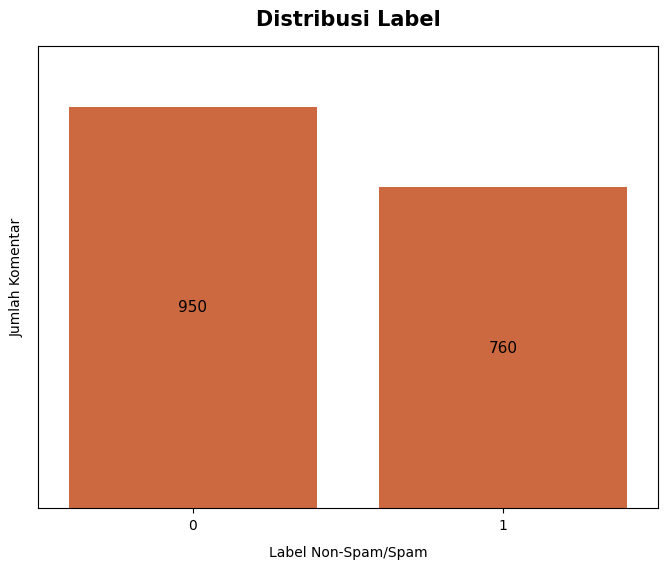

In [13]:
plt.figure(figsize=(8, 6))
#sns.set_palette(["#e85d26"])

ax = sns.countplot(x=df['CLASS'], color='#e55f28')
plt.title(
    'Distribusi Label',
    fontsize=15,
    fontweight='bold',
    pad=15
)
ax.set_xlabel('Label Non-Spam/Spam', labelpad=10)
ax.set_ylabel('Jumlah Komentar', labelpad=10)
ax.grid(False)

max_val = df['CLASS'].value_counts().max()
ax.set_ylim(0, max_val * 1.15)

ax.tick_params(axis='y', which='both', left=False, labelleft=False)

for p in ax.patches:
    height = p.get_height()
    x = p.get_x() + p.get_width() / 2
    ax.text(x, height / 2, int(height),
            ha='center', va='center', fontsize=11, color='black')

plt.show()

In [14]:
monthly_counts = df.groupby(['YEAR_MONTH', 'CLASS']).size().unstack(fill_value=0)
monthly_counts.columns = ['Non-Spam', 'Spam']
#monthly_counts = monthly_counts.reset_index()
monthly_counts = monthly_counts.reset_index().set_index('YEAR_MONTH')
print(monthly_counts)

            Non-Spam  Spam
YEAR_MONTH                
2013-07           14    24
2013-08            0    39
2013-09           21    22
2013-10           31    41
2013-11            3    25
2013-12            1     5
2014-01           20    24
2014-07           17    13
2014-08            6    47
2014-09           74    64
2014-10           58    62
2014-11          180   159
2014-12            0    22
2015-01            0    33
2015-02            0    25
2015-03            0    36
2015-04            0    36
2015-05          517    74
2015-06            8     9


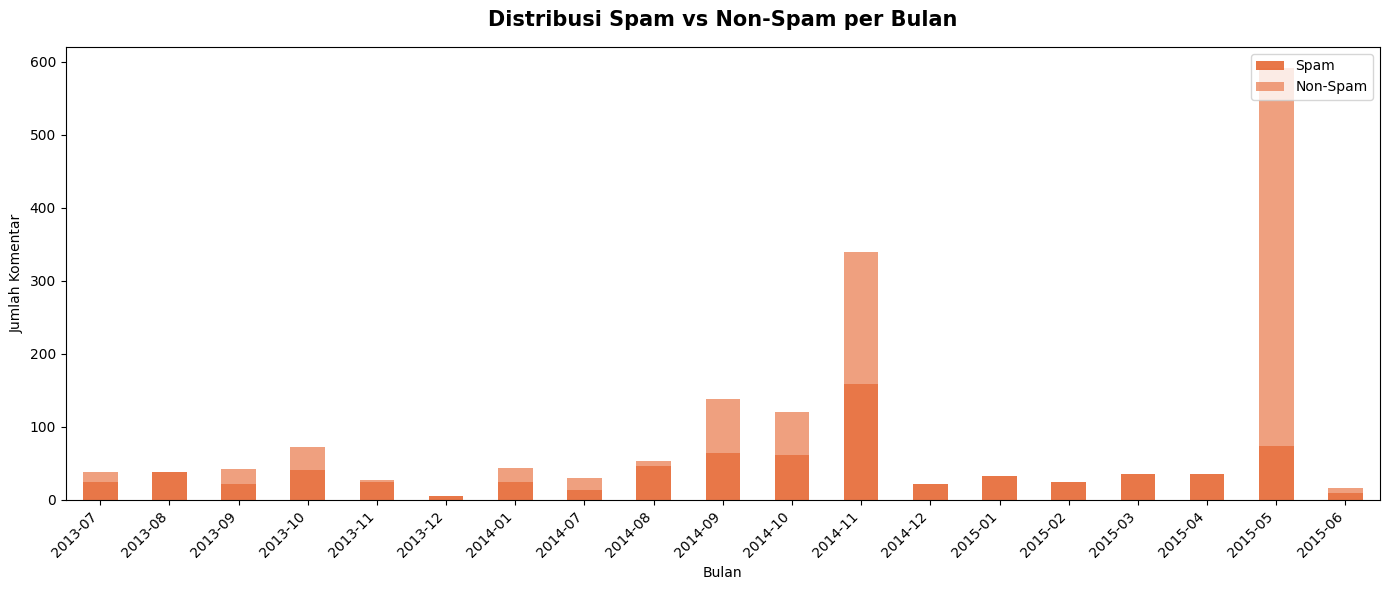

In [15]:
ax = monthly_counts[['Spam', 'Non-Spam']].plot(
    kind='bar',
    stacked=True,
    figsize=(14, 6),
    color=['#e55f28', '#ed8f69'],
    alpha=0.85
)
plt.title(
    'Distribusi Spam vs Non-Spam per Bulan',
    fontsize=15,
    fontweight='bold',
    pad=15
    )
plt.xlabel('Bulan')
plt.ylabel('Jumlah Komentar')
plt.legend(loc='upper right')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
#plt.savefig("/content/drive/My Drive/포트폴리오/📊 데이터 분석/프로젝트 3/Distribusi Spam vs Non-Spam per Bulan.png", dpi=300, bbox_inches='tight')
plt.show()

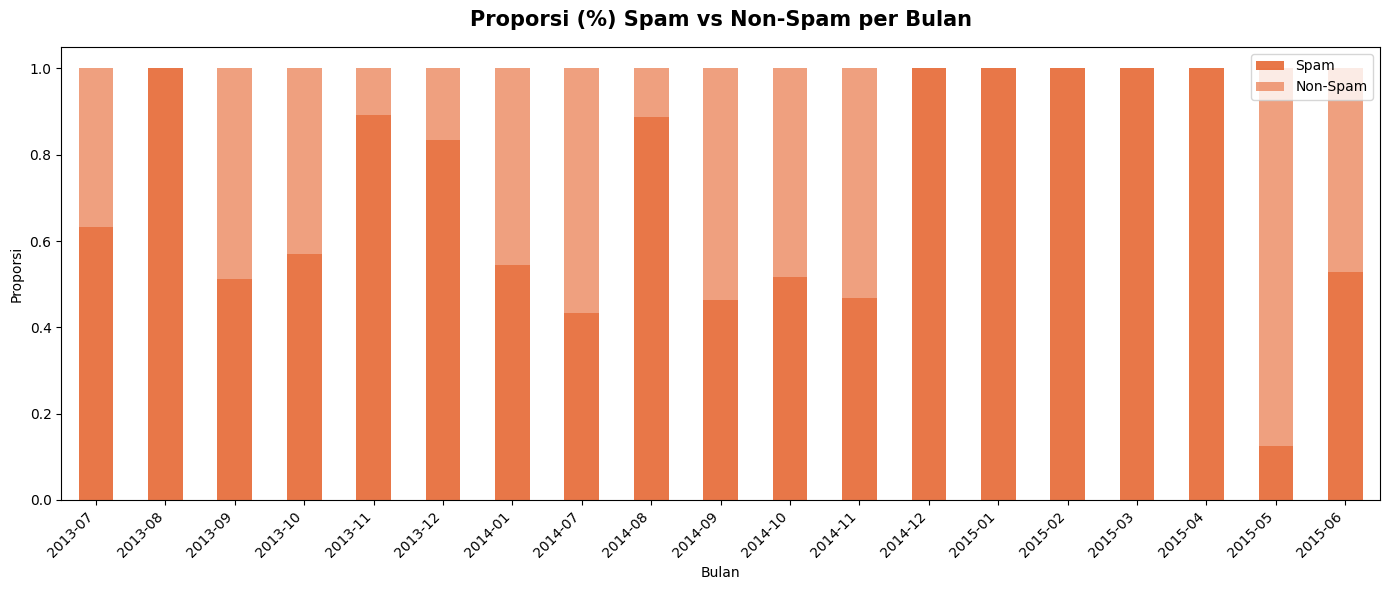

In [16]:
prop_df = monthly_counts.div(monthly_counts.sum(axis=1), axis=0)

ax = prop_df[['Spam', 'Non-Spam']].plot(
    kind='bar',
    stacked=True,
    figsize=(14, 6),
    color=['#e55f28', '#ed8f69'],
    alpha=0.85
)
plt.title(
    'Proporsi (%) Spam vs Non-Spam per Bulan',
    fontsize=15,
    fontweight='bold',
    pad=15
    )
plt.xlabel('Bulan')
plt.ylabel('Proporsi')
plt.legend(loc='upper right')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
#plt.savefig("/content/drive/My Drive/포트폴리오/📊 데이터 분석/프로젝트 3/Proporsi (%) Non-Spam vs Spam per Bulan.png", dpi=300, bbox_inches='tight')
plt.show()

In [17]:
video_counts = df['VIDEO_NAME'].value_counts().reset_index()
video_counts.columns = ['VIDEO_NAME', 'Jumlah Komentar']
print(video_counts)

                                          VIDEO_NAME  Jumlah Komentar
0  lmfao - party rock anthem ft. lauren bennett, ...              438
1                                shakira - waka waka              369
2                     psy - gangnam style(?????) m/v              350
3                                  katy perry - roar              350
4          eminem - love the way you lie ft. rihanna              203


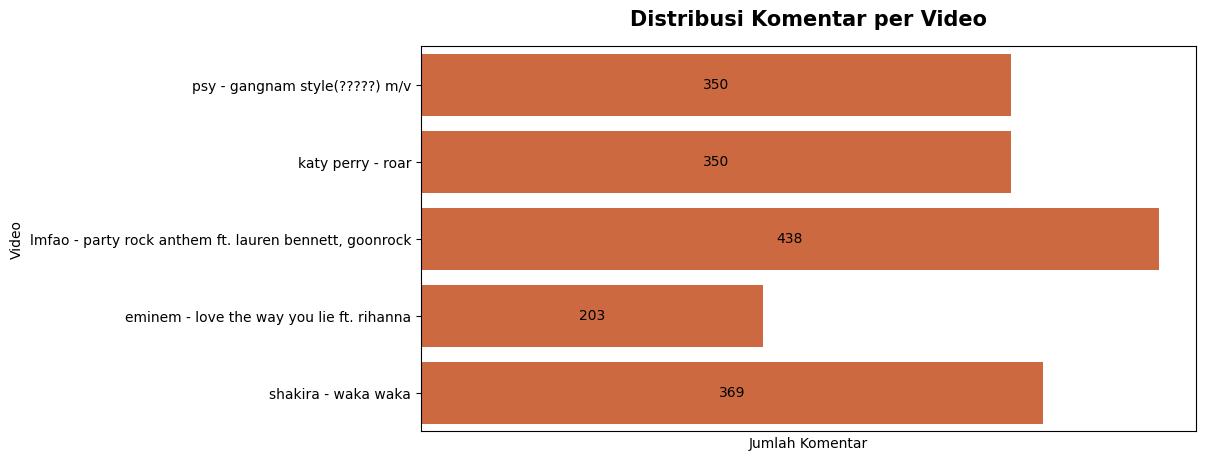

In [18]:
plt.figure(figsize=(10, 5))

ax = sns.countplot(y=df['VIDEO_NAME'], color='#e55f28')
plt.title(
    'Distribusi Komentar per Video',
    fontsize=15,
    fontweight='bold',
    pad=15
)
plt.xlabel('Jumlah Komentar')
plt.ylabel('Video')
ax.grid(False)

for p in ax.patches:
    width = p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.text(width / 2, y, int(width),
            ha='center', va='center', fontsize=10, color='black')
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.show()

In [19]:
spam_counts = df.groupby(['VIDEO_NAME', 'CLASS']).size().unstack(fill_value=0)
spam_counts.columns = ['No Spam', 'Spam']
print(spam_counts)

                                                    No Spam  Spam
VIDEO_NAME                                                       
eminem - love the way you lie ft. rihanna               203     0
katy perry - roar                                       175   175
lmfao - party rock anthem ft. lauren bennett, g...      202   236
psy - gangnam style(?????) m/v                          175   175
shakira - waka waka                                     195   174


<Figure size 1000x500 with 0 Axes>

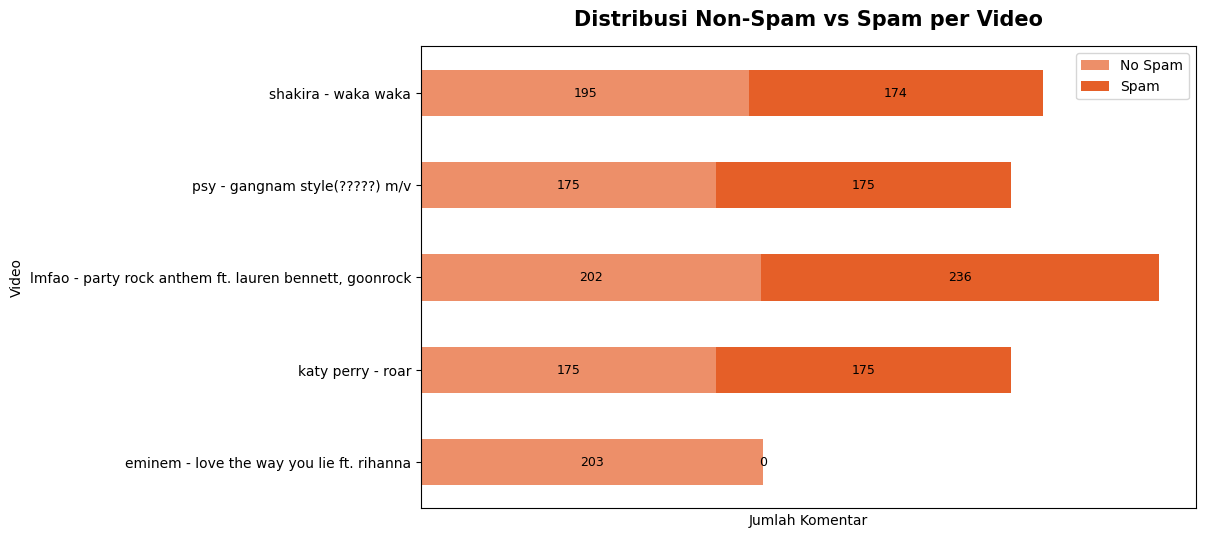

In [20]:
plt.figure(figsize=(10, 5))

ax = spam_counts[['No Spam', 'Spam']].plot(
    kind='barh',
    stacked=True,
    figsize=(10,6),
    color = ['#ed8f69','#e55f28']
)
plt.title(
    'Distribusi Non-Spam vs Spam per Video',
    fontsize=15,
    fontweight='bold',
    pad=15
    )
plt.xlabel('Jumlah Komentar')
plt.ylabel('Video')
ax.grid(False)

for i, (index, row) in enumerate(spam_counts.iterrows()):
    no_spam = row['No Spam']
    spam = row['Spam']
    plt.text(no_spam / 2, i, str(int(no_spam)), va='center', ha='center', fontsize=9, color='black')
    plt.text(no_spam + spam / 2, i, str(int(spam)), va='center', ha='center', fontsize=9, color='black')

ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
plt.savefig("/content/drive/My Drive/포트폴리오/📊 데이터 분석/프로젝트 3/Distribusi Non-Spam vs Spam per Video.png", dpi=300, bbox_inches='tight')
plt.show()

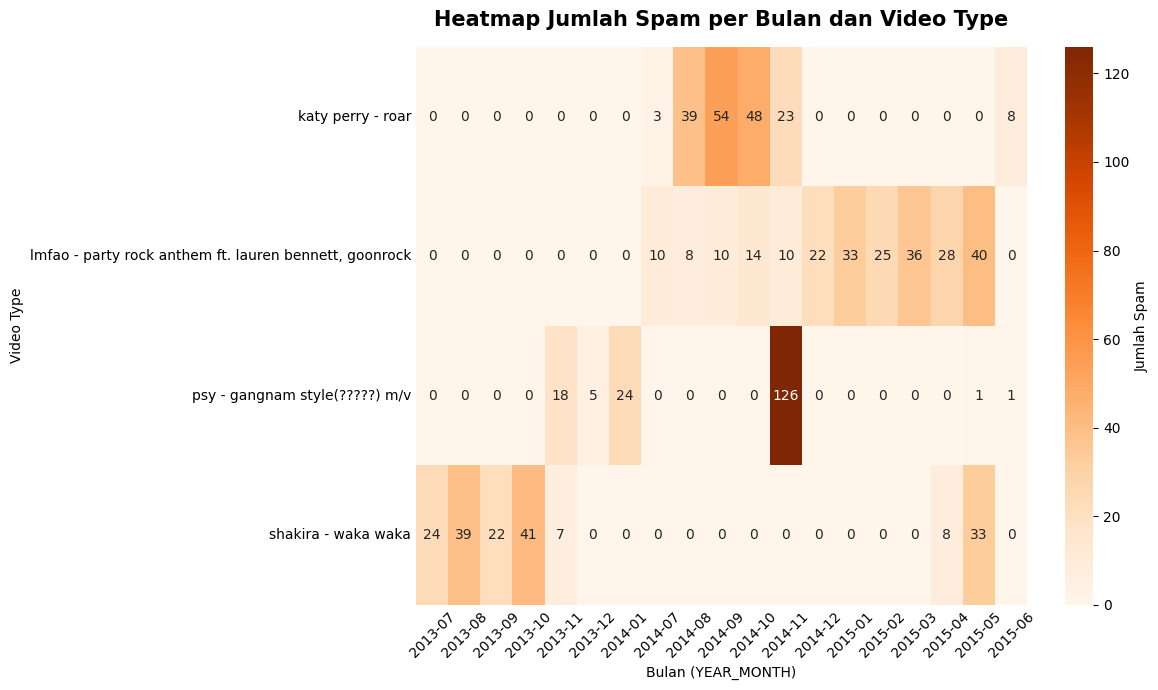

In [21]:
df_spam = df[df['CLASS'] == 1]
heatmap_data = df_spam.groupby(['YEAR_MONTH', 'VIDEO_NAME']).size().reset_index(name='JUMLAH_SPAM')

heatmap_pivot = heatmap_data.pivot(
    index='VIDEO_NAME',
    columns='YEAR_MONTH',
    values='JUMLAH_SPAM'
).fillna(0)
plt.figure(figsize=(12, 7))
ax = sns.heatmap(
    heatmap_pivot,
    annot=True,
    fmt='.0f',
    cmap='Oranges',
    cbar_kws={'label': 'Jumlah Spam'}
)
plt.title(
    'Heatmap Jumlah Spam per Bulan dan Video Type',
    fontsize=15,
    fontweight='bold',
    pad=15
)
plt.xlabel('Bulan (YEAR_MONTH)')
plt.ylabel('Video Type')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
ax.tick_params(axis='both', which='both', length=0)
plt.tight_layout()
plt.savefig("/content/drive/My Drive/포트폴리오/📊 데이터 분석/프로젝트 3/Heatmap Jumlah Spam per Bulan dan Video Type.png", dpi=300, bbox_inches='tight')
plt.show()

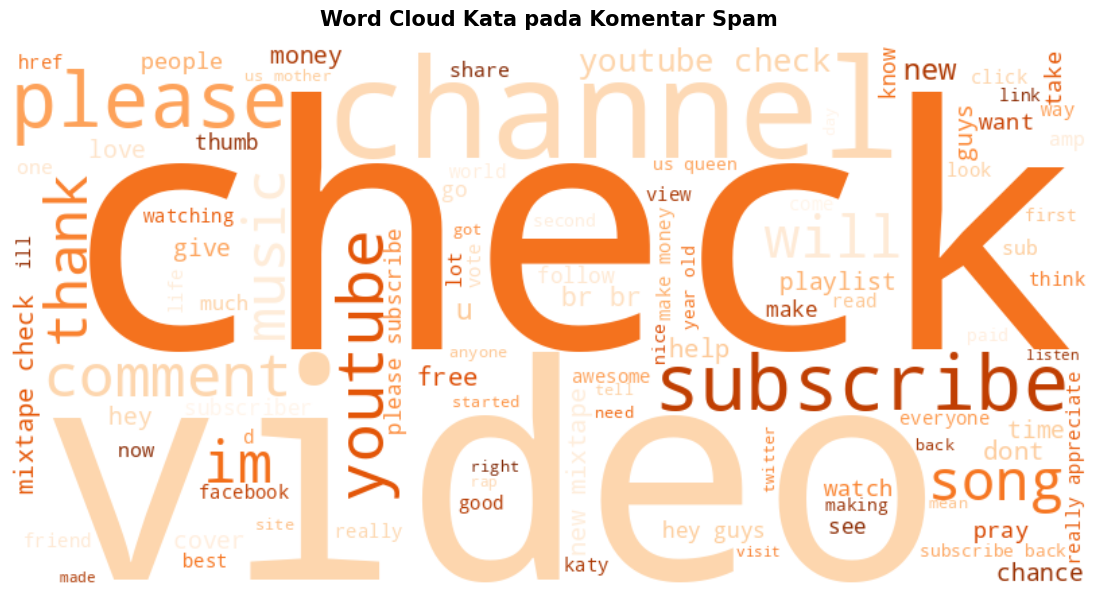

In [22]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['CONTENT_CLEAN'] = df['CONTENT'].apply(clean_text)

spam_comments = df[df['CLASS'] == 1]['CONTENT_CLEAN'].dropna().astype(str)
text = " ".join(spam_comments)
stopwords = set(STOPWORDS)
stopwords.update(["https", "http", "com", "www"])
wordcloud = WordCloud(
    width=800,
    random_state = 42,
    height=400,
    background_color='white',
    colormap='Oranges',
    max_words=100
).generate(text)
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(
    'Word Cloud Kata pada Komentar Spam',
    fontsize=15,
    fontweight='bold',
    pad=15
    )
#plt.savefig("/content/drive/My Drive/포트폴리오/📊 데이터 분석/프로젝트 3/chart4_wordcloud.png", dpi=300, bbox_inches='tight')
plt.show()

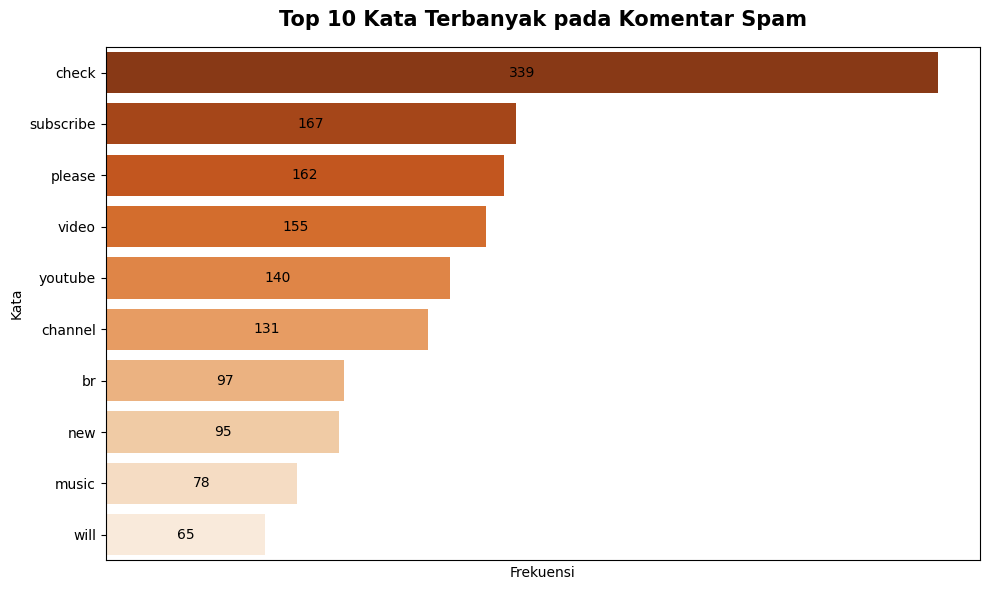

In [23]:
from collections import Counter

words_list = text.split()
words_list = [word for word in words_list if word not in stopwords]
word_counts = Counter(words_list)
top_10 = word_counts.most_common(10)

words, counts = zip(*top_10)

top_words_df = pd.DataFrame({
    'word': list(words),
    'count': list(counts)
})
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x='count',
    y='word',
    hue='word',
    data=top_words_df,
    palette='Oranges_r',
    dodge=False,
    legend=False
)
plt.title(
    'Top 10 Kata Terbanyak pada Komentar Spam',
    fontsize=15,
    fontweight='bold',
    pad=15
)
plt.xlabel('Frekuensi')
plt.ylabel('Kata')
ax.grid(False)

for p in ax.patches:
    width = p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.text(width / 2, y, int(width),
            ha='center', va='center', fontsize=10, color='black')

ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tight_layout()
plt.savefig("/content/drive/My Drive/포트폴리오/📊 데이터 분석/프로젝트 3/Top 10 Kata Terbanyak pada Komentar Spam.png", dpi=300, bbox_inches='tight')
plt.show()

In [24]:
df['AUTHOR'].value_counts()

,count
AUTHOR,
shadrach grentz,7
5000palo,7
luckymusiqlive,5
hidden love,5
james cook,4
...,...
ambareesh nimkar,1
b0b1t.48058475,1
imscarlet,1


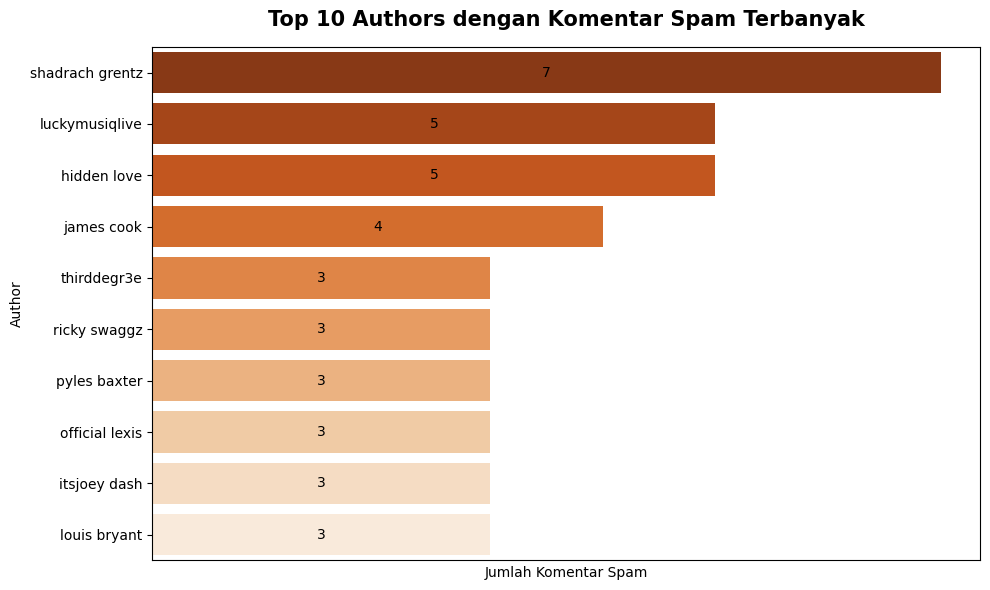

In [25]:
df_spam = df[df['CLASS'] == 1]
author_counts = df_spam['AUTHOR'].value_counts().head(10)

top_authors_df = pd.DataFrame({
    'author': author_counts.index,
    'count': author_counts.values
})
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x='count',
    y='author',
    hue='author',
    data=top_authors_df,
    palette='Oranges_r',
    dodge=False,
    legend=False
)
plt.title(
    'Top 10 Authors dengan Komentar Spam Terbanyak',
    fontsize=15,
    fontweight='bold',
    pad=15
)
plt.xlabel('Jumlah Komentar Spam')
plt.ylabel('Author')
ax.grid(False)

for p in ax.patches:
    width = p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.text(width / 2, y, int(width),
            ha='center', va='center', fontsize=10, color='black')

ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tight_layout()
#plt.savefig("/content/drive/My Drive/포트폴리오/📊 데이터 분석/프로젝트 3/Top 10 Authors dengan Komentar Spam Terbanyak.png", dpi=300, bbox_inches='tight')
plt.show()

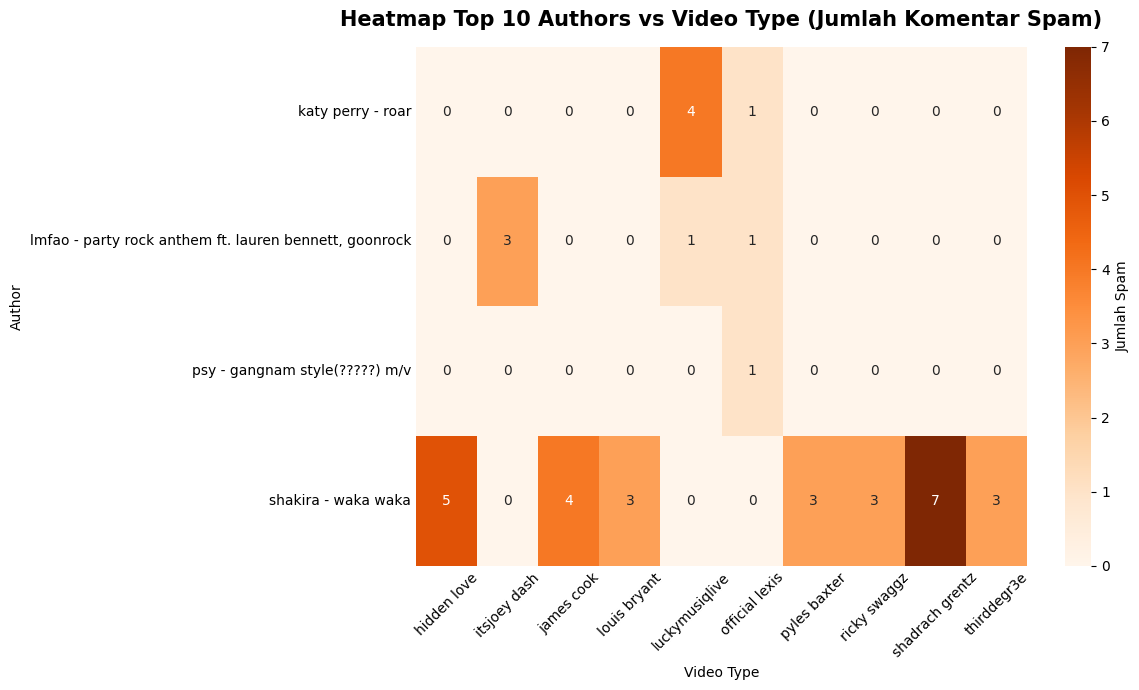

In [26]:
author_video_counts = df_spam.groupby(['AUTHOR', 'VIDEO_NAME']).size().reset_index(name='JUMLAH_SPAM')

top_10_authors = author_counts.index.tolist()
heatmap_df = author_video_counts[author_video_counts['AUTHOR'].isin(top_10_authors)]

heatmap_pivot = heatmap_df.pivot(
    columns='AUTHOR',
    index ='VIDEO_NAME',
    values='JUMLAH_SPAM'
).fillna(0)

plt.figure(figsize=(12, 7))
ax = sns.heatmap(
    heatmap_pivot,
    annot=True,
    fmt='.0f',
    cmap='Oranges',
    cbar_kws={'label': 'Jumlah Spam'}
)
plt.title(
    'Heatmap Top 10 Authors vs Video Type (Jumlah Komentar Spam)',
    fontsize=15,
    fontweight='bold',
    pad=15
)
plt.xlabel('Video Type')
plt.ylabel('Author')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
ax.tick_params(axis='both', which='both', length=0)
plt.tight_layout()
#plt.savefig("/content/drive/My Drive/포트폴리오/📊 데이터 분석/프로젝트 3/Heatmap Top 10 Authors vs Video Type", dpi=300, bbox_inches='tight')
plt.show()

## 30 Sampel untuk LLM

In [27]:
df_spam_sample = (
    df[df['CLASS'] == 1]
    .groupby(['VIDEO_NAME', 'YEAR_MONTH'])
    .apply(lambda x: x.sample(1, random_state=42))
    .reset_index(drop=True)
)
df_spam_sample = df_spam_sample.sample(n=15, random_state=42)
df_nonspam_sample = (
    df[df['CLASS'] == 0]
    .groupby(['VIDEO_NAME', 'YEAR_MONTH'])
    .apply(lambda x: x.sample(1, random_state=42))
    .reset_index(drop=True)
)

df_nonspam_sample = df_nonspam_sample.sample(n=15, random_state=42)
df_sample_for_llm = pd.concat([df_spam_sample, df_nonspam_sample])
df_sample_for_llm = df_sample_for_llm.sample(frac=1, random_state=42).reset_index(drop=True)
df_sample_for_llm_simple = df_sample_for_llm[['CONTENT', 'CLASS']]
df_sample_for_llm_simple.to_csv("sample_30_for_llm.csv", index=False)

from google.colab import files
#files.download("sample_30_for_llm.csv")

/tmp/ipython-input-27-3413401696.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(1, random_state=42))
/tmp/ipython-input-27-3413401696.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(1, random_state=42))


In [28]:
pd.set_option('display.max_colwidth', None)
print(df_sample_for_llm_simple)

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                CONTENT  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        lmfa